In [3]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.nn import functional as F
import torch

In [10]:
class Network(torch.nn.Module):
    def __init__(self):

        super(Network, self).__init__()
        
        self.initial_conv_layers = nn.Sequential(
                                nn.Conv2d(3, 16, 9), # x-8
                                nn.PReLU(),
                                nn.Conv2d(16, 32, 7), # x-8-6 = x-14
                                nn.PReLU()
                              )
        
        self.gdf_conv1 = nn.Conv2d(32, 16, 9)
        self.gdf_max1 = nn.MaxPool2d(2)
        self.gdf_avg1 = nn.AvgPool2d(2)
        self.gdf_prelu1 = nn.PReLU()
        
        self.gdf_conv2 = nn.Conv2d(16, 32, 7)
        self.gdf_max2 = nn.MaxPool2d(2)
        self.gdf_avg2 = nn.AvgPool2d(2)
        self.gdf_prelu2 = nn.PReLU()
        
        self.gdf_conv3_block = nn.Sequential(
                            nn.Conv2d(32, 16, 7, 1, 3), # x-6 + 6 = x
                            nn.PReLU(),
#                             nn.Conv2d(16, 8, 7, 1, 3), 
                            nn.Conv2d(16, 8, 6, 1, 4), #Trying to get all WxH same x-5+8 = x+3
                            nn.PReLU()
                          )
        
        self.gdf_adp = nn.AdaptiveMaxPool2d((64,64))
        self.gdf_adp_prelu = nn.PReLU()
        
        self.gdf_fc_block = nn.Sequential(
            nn.Linear(64*64*8, 512),
            nn.PReLU(),
            nn.Linear(512, 5)
        )
        
        self.cc1_conv1 = nn.Conv2d(32, 20, 7)
        self.cc1_max1 = nn.MaxPool2d(2)
        self.cc1_avg1 = nn.AvgPool2d(2)
        self.cc1_prelu1 = nn.PReLU()
        
        self.cc1_conv2 = nn.Conv2d(20, 40, 5)
        self.cc1_max2 = nn.MaxPool2d(2)
        self.cc1_avg2 = nn.AvgPool2d(2)
        self.cc1_prelu2 = nn.PReLU()
        
        self.cc1_conv3_block = nn.Sequential(
                            nn.Conv2d(40, 20, 5, 1, 2), # x - 4 + 4 = x
                            nn.PReLU(),
#                             nn.Conv2d(20, 10, 5, 1, 2), 
                            nn.Conv2d(20, 10, 4, 1, 2), # Trying to make all WxH same  x-3+4 = x+1
                            nn.PReLU()
                          )
        
        
        self.cc2_conv1 = nn.Conv2d(32, 24, 5)
        self.cc2_max1 = nn.MaxPool2d(2)
        self.cc2_avg1 = nn.AvgPool2d(2)
        self.cc2_prelu1 = nn.PReLU()
        
        self.cc2_conv2 = nn.Conv2d(24, 48, 3)
        self.cc2_max2 = nn.MaxPool2d(2)
        self.cc2_avg2 = nn.AvgPool2d(2)
        self.cc2_prelu2 = nn.PReLU()
        
        self.cc2_conv3_block = nn.Sequential(
                            nn.Conv2d(48, 24, 3, 1, 1), # x-2+2 = x
                            nn.PReLU(),
                            nn.Conv2d(24, 12, 3, 1, 1), #x-2+2 = x
                            nn.PReLU()
                          )
        

        self.out_block = nn.Sequential(
                        nn.Conv2d(30, 24, 3, 1, 1), # 24, 50-2+2 = 50 (x)
                        nn.PReLU(),
                        nn.Conv2d(24, 32, 3, 1, 1), # 32, 50-2+2 = 50 (x)
                        nn.PReLU(),
                        nn.ConvTranspose2d(32, 16, 7, 2, 1, dilation=2), # 16, (50-1)*2 - 2*1 + 1*(3-1) + 1 = 99 (2*x-1)
                        nn.PReLU(),
                        nn.ConvTranspose2d(16, 8, 6, 2, 1, dilation=2), # 8, (99-1)*2 - 2*1 + 1*(3-1) + 1 = 197 (4*x-3)
                        nn.PReLU(),
                        nn.Conv2d(8, 8, 1), # 8, 197
                        nn.PReLU(),
                        nn.Conv2d(8, 1, 1) # 1, 197
                    )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initial batch_sizex3x225x225
#         print(x.shape)
        pre_x = self.initial_conv_layers(x)  # 32,225-14 = 211 (x-14)
        
        # sub task 1
        
        gd_x = self.gdf_conv1(pre_x) # 211-8 = 16,203 (x-22)
        gd_x = self.gdf_max1(gd_x) + self.gdf_avg1(gd_x) # 203/2 = 101 ((x-22)/2)
        gd_x = self.gdf_prelu1(gd_x) 
        
        gd_x = self.gdf_conv2(gd_x) # 32,101-6 = 95 ((x-22)/2 - 6) = ((x-34)/2)
        gd_x = self.gdf_max2(gd_x) + self.gdf_avg2(gd_x) # 95/2 = 47 ((x-34)/4)
        gd_x = self.gdf_prelu2(gd_x) 
        
#         print("Before gd_b: ", gd_x.shape)
        
        gd_out = self.gdf_conv3_block(gd_x) # 8, 47+3 = 50 (x-34/4 + 3 = (x-22/4))
        
#         print("After gd_b: ", gd_out.shape)

        
        gd_b = self.gdf_adp(gd_out) # 8, 64
        gd_b = self.gdf_adp_prelu(gd_b)
#         print('Shape after gd adaptive pooling is: ',gd_b.shape)
#         gd_b = gd_b.reshape(-1) 
        gd_b = torch.flatten(gd_b, 1)
#         print('Shape after flatten is: ',gd_b.shape)
        gd_b = self.gdf_fc_block(gd_b)
        
        # sub task 2
        
        # First branch
        cc_1 = self.cc1_conv1(pre_x) # 20, 211-6 = 205 (x-20)
        cc_1 = self.cc1_max1(cc_1) + self.cc1_avg1(cc_1) # 205/2 = 102 (x-20/2)
        cc_1 = self.cc1_prelu1(cc_1)
        
        cc_1 = self.cc1_conv2(cc_1) # 40, 102-4 = 98 ((x-20)/2 - 4 = (x-28)/2)
        cc_1 = self.cc1_max2(cc_1) + self.cc1_avg2(cc_1) # 98/2 = 49 ((x-28)/4)
        cc_1 = self.cc1_prelu2(cc_1)
        
#         print("Before cc block: ", cc_1.shape)
        
        cc_1 = self.cc1_conv3_block(cc_1) # 10, 49+1 = 50
#         print("cc_1 shape is: ", cc_1.shape)

        
        # Second branch
        cc_2 = self.cc2_conv1(pre_x) # 24, 211-4 = 207 (x-18)
        cc_2 = self.cc2_max1(cc_2) + self.cc2_avg1(cc_2) # 207/2 = 103 ((x-18)/2)
        cc_2 = self.cc2_prelu1(cc_2)
        
        cc_2 = self.cc2_conv2(cc_2) # 48, 103-2 = 101 ((x-18)/2 - 2 = (x-22)/2)
        cc_2 = self.cc2_max2(cc_2) + self.cc2_avg2(cc_2) # 101/2 = 50 (x-22/4)
        cc_2 = self.cc2_prelu2(cc_2)
#         print("Before cc block: ", cc_2.shape)
        
        cc_2 = self.cc2_conv3_block(cc_2) # 12, 50
        
#         print("cc_2 shape is: ", cc_2.shape)
        
#         print(f"gd_out shape is {gd_out.shape}\n cc1 shape is {cc_1.shape}\n cc2 shape is {cc_2.shape}\n")
        cc_out = torch.cat((gd_out, cc_1, cc_2), dim=1) # 30, 50
#         print("out shape is: ", cc_out.shape)
        out = self.out_block(cc_out)        
#         print("after out shape is: ", out.shape)
        out = self.sigmoid(out)
        
        return gd_b, out

In [147]:
import torch
import gdown
from PIL import Image
from torchvision import transforms
import gradio as gr
import cv2
import numpy as np
import scipy

model_path = 'model.pth'
device = 'cuda'
model = Network()
model.to(device)
model.load_state_dict(torch.load(model_path, device))
model.eval()


def predict(inp):
    inp = Image.fromarray(inp.astype('uint8'), 'RGB')
    preprocess = transforms.Compose([
       transforms.Resize((225, 225)),
       transforms.ToTensor(),
    ])

    inp = preprocess(inp)
    print(inp.shape)
    inp = inp.unsqueeze(0)
    inp = inp.to(device)
    with torch.set_grad_enabled(False):
        level, outputs = model(inp)
    _, count = torch.topk(level, 1)
    count = count.item() + 1
    vis_img = outputs[0, 0].cpu().numpy()
    print(vis_img.shape)
    # normalize density map values from 0 to 1, then map it to 0-255.
    vis_img = (vis_img - vis_img.min()) / (vis_img.max() - vis_img.min() + 1e-5)
    vis_img = (vis_img * 255).astype(np.uint8)
    
    vis_img = cv2.applyColorMap(vis_img, cv2.COLORMAP_JET)
    vis_img = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
    return vis_img, int(count)


title = "Crowd Counting"
desc = "Demo"
examples = [
    ["../ShanghaiTech/part_A/test_data/images/IMG_10.jpg"],
    ["../ShanghaiTech/part_A/test_data/images/IMG_11.jpg"],
    ["../ShanghaiTech/part_A/test_data/images/IMG_12.jpg"],
]
inputs = gr.inputs.Image(label="Image of Crowd")
outputs = [gr.outputs.Image(label="Predicted Density Map"), gr.outputs.Label(label="Predicted Count")]
gr.Interface(fn=predict, inputs=inputs, outputs=outputs, title=title, description=desc, examples=examples,
             allow_flagging=False).launch()

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for gdf_conv3_block.2.weight: copying a param with shape torch.Size([8, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([8, 16, 6, 6]).
	size mismatch for cc1_conv3_block.2.weight: copying a param with shape torch.Size([10, 20, 5, 5]) from checkpoint, the shape in current model is torch.Size([10, 20, 4, 4]).
	size mismatch for cc2_conv3_block.2.weight: copying a param with shape torch.Size([12, 24, 4, 4]) from checkpoint, the shape in current model is torch.Size([12, 24, 3, 3]).
	size mismatch for out_block.4.weight: copying a param with shape torch.Size([32, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 16, 7, 7]).
	size mismatch for out_block.6.weight: copying a param with shape torch.Size([16, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 8, 6, 6]).

In [109]:
a = cv2.imread(r"D:\Git\Crowd_Counting\ShanghaiTech\part_A\test_data\images\IMG_71.jpg")

In [110]:
a.shape

(763, 1024, 3)

In [111]:
b=np.resize(a, (225,225,3))

In [112]:
c = torch.Tensor(b)

In [113]:
d = c.unsqueeze(0)

In [114]:
d.shape

torch.Size([1, 225, 225, 3])

In [115]:
e = d.permute(0, 3, 1, 2)

In [116]:
e = e.to(device)

In [117]:
e.shape

torch.Size([1, 3, 225, 225])

In [118]:
level, density = model(e)

In [119]:
level

tensor([[  86031.2266,   64678.1445,   51389.2617,   27065.5586, -110605.9453]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [144]:
_, idx = torch.topk(level, k=1).item()

AttributeError: 'torch.return_types.topk' object has no attribute 'item'

In [135]:
s = idx[0][0].cpu().numpy()

In [143]:
idx.item()

0

In [93]:
density[0][0].shape

torch.Size([225, 225])

In [94]:
import matplotlib.pyplot as plt

In [95]:
x = np.meshgrid(density[0][0].cpu().detach().numpy())

In [96]:
pppp = density[0].cpu().detach()

In [97]:
sp = pppp.permute(1,2,0).numpy()

In [98]:
sp.shape

(225, 225, 1)

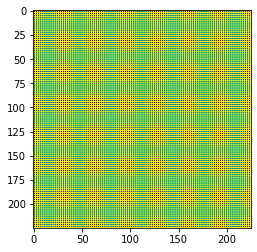

In [99]:
plt.imshow(sp)

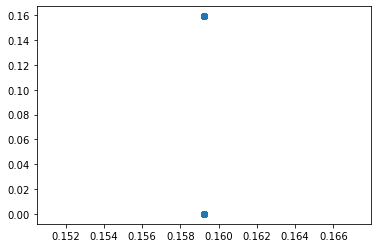

In [62]:
plt.scatter(pppp[:, 0], pppp[:, 1])

In [51]:
density[0][0].cpu().detach().numpy()

TypeError: scatter() missing 1 required positional argument: 'y'

In [115]:
with open('./train-0516-181021_VGG.log') as f:
    k = f.read()

In [120]:
d = {}
d_v = {}
for i in range(1,len(l)):
    if 'Train' in l[i]:
        my_l = l[i].split(',')[2:]
        for j in my_l:
            li = j.split(':')
            if len(li) == 2:
                lo, va = li
                lo = lo.strip()
                va = float(va.strip())
                if lo in d:
                    d[lo].append(va)
                else:
                    d[lo] = [va]
            elif len(li)==3:
    #             print(j)
                lo1, va1 = j.split('MAE')[0].split(':')
                lo2, va2 = j[len(j.split('MAE')[0]):].split(':')
                lo1 = lo1.strip()
                va1 = float(va1.strip())
                if lo1 in d:
                    d[lo1].append(va1)
                else:
                    d[lo1] = [va1]
                lo2 = lo2.strip()
                va2 = float(va2.strip())
                if lo2 in d:
                    d[lo2].append(va2)
                else:
                    d[lo2] = [va2]
    elif 'Val' in l[i]:
        j = l[i].split(',')[2]
        lo1, va1 = j.split('MAE')[0].split(':')
        lo2, va2 = j[len(j.split('MAE')[0]):].split(':')
        lo1 = lo1.strip()
        va1 = float(va1.strip())
        if lo1 in d_v:
            d_v[lo1].append(va1)
        else:
            d_v[lo1] = [va1]
        lo2 = lo2.strip()
        va2 = float(va2.strip())
        if lo2 in d_v:
            d_v[lo2].append(va2)
        else:
            d_v[lo2] = [va2]

In [121]:
import matplotlib.pyplot as plt

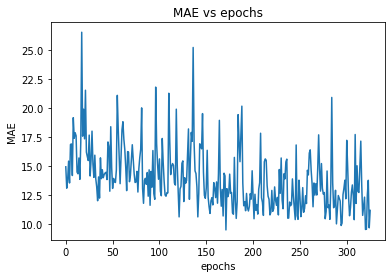

In [127]:
s = 'MAE'
plt.title(f'{s} vs epochs')
plt.xlabel('epochs')
plt.ylabel(s)
plt.plot(d[s])
plt.show()

In [83]:
print(d.keys())

dict_keys(['Loss', 'OT Loss', 'Wass Distance', 'OT obj value', 'Count Loss', 'TV Loss', 'MSE', 'MAE'])


In [92]:
d_v.keys()

dict_keys(['MSE', 'MAE'])

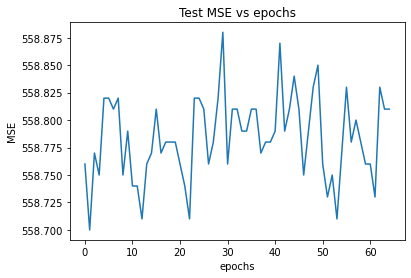

In [129]:
s = 'MSE'
plt.title(f'Test {s} vs epochs')
plt.xlabel('epochs')
plt.ylabel(s)
plt.plot(d_v[s])
plt.show()

## MCNN

In [97]:
with open('./train-0516-154029_MCNN.log') as f:
    k = f.read()

In [102]:
d = {}
d_v = {}
for i in range(1,len(l)):
    if 'Train' in l[i]:
        my_l = l[i].split(',')[2:]
        for j in my_l:
            li = j.split(':')
            if len(li) == 2:
                lo, va = li
                lo = lo.strip()
                va = float(va.strip())
                if lo in d:
                    d[lo].append(va)
                else:
                    d[lo] = [va]
            elif len(li)==3:
    #             print(j)
                lo1, va1 = j.split('MAE')[0].split(':')
                lo2, va2 = j[len(j.split('MAE')[0]):].split(':')
                lo1 = lo1.strip()
                va1 = float(va1.strip())
                if lo1 in d:
                    d[lo1].append(va1)
                else:
                    d[lo1] = [va1]
                lo2 = lo2.strip()
                va2 = float(va2.strip())
                if lo2 in d:
                    d[lo2].append(va2)
                else:
                    d[lo2] = [va2]
    elif 'Val' in l[i]:
        j = l[i].split(',')[2]
        lo1, va1 = j.split('MAE')[0].split(':')
        lo2, va2 = j[len(j.split('MAE')[0]):].split(':')
        lo1 = lo1.strip()
        va1 = float(va1.strip())
        if lo1 in d_v:
            d_v[lo1].append(va1)
        else:
            d_v[lo1] = [va1]
        lo2 = lo2.strip()
        va2 = float(va2.strip())
        if lo2 in d_v:
            d_v[lo2].append(va2)
        else:
            d_v[lo2] = [va2]

In [103]:
import matplotlib.pyplot as plt

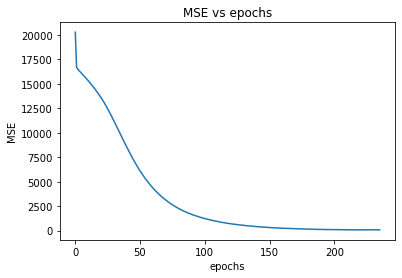

In [110]:
s = 'MSE'
plt.title(f'{s} vs epochs')
plt.xlabel('epochs')
plt.ylabel(s)
plt.plot(d[s])
plt.show()

In [105]:
print(d.keys())

dict_keys(['Loss', 'Level Loss', 'Density Loss', 'MSE', 'MAE'])


In [111]:
d_v.keys()

dict_keys(['MSE', 'MAE'])

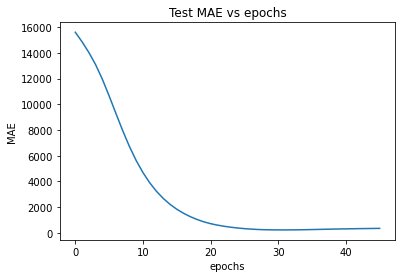

In [114]:
s = 'MAE'
plt.title(f'Test {s} vs epochs')
plt.xlabel('epochs')
plt.ylabel(s)
plt.plot(d_v[s])
plt.show()